In [1]:
import pandas as pd
import numpy as np
import regex as re

import warnings
import itertools

from datetime import datetime

import statistics

import matplotlib.pyplot as plt
from pylab import rcParams

import seaborn as sns

import scipy.stats as stats
from scipy.stats import norm
from statsmodels.stats.weightstats import ztest


import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### LIMPIEZA DE DATOS

In [3]:
data_2021 = pd.read_csv('/content/drive/MyDrive/Población Mundial/2021_population.csv')
                      

In [4]:
data_2022 = pd.read_csv('/content/drive/MyDrive/Población Mundial/2022_population.csv')

In [5]:
data_2022.head()

,iso_code,country,2022_last_updated,2020_population,area,density_sq_km,growth_rate,world_%,rank
0,CHN,China,"1,446,968,248","1,439,323,776","9,706,961 sq_km",149/sq_km,0.29%,18.21%,1
1,IND,India,"1,401,989,734","1,380,004,385","3,287,590 sq_km",428/sq_km,0.95%,17.68%,2
2,USA,United States,"334,133,861","331,002,651","9,372,610 sq_km",36/sq_km,0.57%,4.21%,3
3,IDN,Indonesia,"278,157,841","273,523,615","1,904,569 sq_km",147/sq_km,1.00%,3.51%,4
4,PAK,Pakistan,"227,985,585","220,892,340","881,912 sq_km",260/sq_km,1.90%,2.89%,5


In [6]:
p_2021 = data_2021['2021_last_updated']
data_2022['2021_population'] = p_2021

In [7]:
data_2022 = data_2022[['iso_code', 'country', '2022_last_updated', '2021_population', '2020_population', 
                       'area', 'density_sq_km', 'growth_rate', 'world_%', 'rank']]

In [8]:
data_2022.head()

,iso_code,country,2022_last_updated,2021_population,2020_population,area,density_sq_km,growth_rate,world_%,rank
0,CHN,China,"1,446,968,248","1,447,065,329","1,439,323,776","9,706,961 sq_km",149/sq_km,0.29%,18.21%,1
1,IND,India,"1,401,989,734","1,401,310,563","1,380,004,385","3,287,590 sq_km",428/sq_km,0.95%,17.68%,2
2,USA,United States,"334,133,861","334,058,426","331,002,651","9,372,610 sq_km",36/sq_km,0.57%,4.21%,3
3,IDN,Indonesia,"278,157,841","278,037,263","273,523,615","1,904,569 sq_km",147/sq_km,1.00%,3.51%,4
4,PAK,Pakistan,"227,985,585","227,724,796","220,892,340","881,912 sq_km",260/sq_km,1.90%,2.89%,5


In [9]:
def cleaning(data, column):
  data[column] = data[column].str.replace(',','')
  data[column] = data[column].str.replace('%','')
  data[column] = data[column].str.replace('/sq_km','')
  data[column] = data[column].str.replace(' sq_km','')

  data[column] = pd.to_numeric(data[column])

  return cleaning

In [10]:
cleaning(data_2022,'2022_last_updated')
cleaning(data_2022,'2021_population')
cleaning(data_2022,'2020_population')
cleaning(data_2022,'area')
cleaning(data_2022,'density_sq_km')
cleaning(data_2022,'world_%')
cleaning(data_2022,'growth_rate')

<function __main__.cleaning>

In [11]:
world_porce = data_2022.sort_values('world_%', ascending=False)

In [12]:
world_porce[world_porce['country'] == 'United States']


,iso_code,country,2022_last_updated,2021_population,2020_population,area,density_sq_km,growth_rate,world_%,rank
2,USA,United States,334133861,334058426,331002651,9372610,36,0.57,4.21,3


In [13]:
data_2022['world_%'].sum()

98.69

In [14]:
data_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   iso_code           224 non-null    object 
 1   country            224 non-null    object 
 2   2022_last_updated  224 non-null    int64  
 3   2021_population    224 non-null    int64  
 4   2020_population    224 non-null    int64  
 5   area               224 non-null    int64  
 6   density_sq_km      224 non-null    int64  
 7   growth_rate        224 non-null    float64
 8   world_%            224 non-null    float64
 9   rank               224 non-null    int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 17.6+ KB


### AGRUPACIÓN POR CONTINENTE

In [15]:
Europa = ['ALA', 'ALB', 'AND', 'AUT', 'BLR', 'BEL', 'BIH', 'BGR',
          'HRV', 'CZE', 'DNK', 'EST', 'FRO', 'FIN', 'FRA', 'DEU', 'GIB',
          'GRC', 'GGY', 'VAT', 'HUN', 'ISL', 'IRL', 'IMN', 'ITA', 'JEY',
          'LVA', 'LIE', 'LTU', 'LUX', 'MKD', 'MLT', 'MDA', 'MCO', 'MNE',
          'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'RUS', 'SMR', 'SRB', 'SVK', 
          'SVN', 'ESP', 'SJM', 'SWE', 'CHE', 'TUR', 'UKR', 'GBR']

In [16]:
Asia = ['AFG', 'ARM', 'AZE', 'BHR', 'BGD', 'BTN', 'IOT', 'BRN', 'KHM', 'CHN',
        'CXR', 'CCK', 'CYP', 'GEO', 'HKG', 'IND', 'IDN', 'IRN', 'IRQ', 'ISR', 
        'JPN', 'JOR', 'KAZ', 'PRK', 'KOR', 'KWT', 'KGZ', 'LAO', 'LBN', 'MAC', 
        'MYS', 'MDV', 'MNG', 'MMR', 'NPL', 'OMN', 'PAK', 'PSE', 'PHL', 'QAT',
        'SAU', 'SGP', 'LKA', 'SYR', 'TWN', 'TJK', 'THA', 'TLS', 'TKM', 'ARE', 
        'UZB', 'VNM', 'YEM']

In [17]:
America_Nor = ['AIA', 'ATG', 'ABW', 'BHS', 'BRB', 'BLZ', 'BMU', 'BES', 'CAN',
               'CYM', 'CRI', 'CUB', 'CUW', 'DMA', 'DOM', 'SLV', 'GRL', 'GRD', 
               'GLP', 'GTM', 'HTI', 'HND', 'JAM', 'MTQ', 'MEX', 'MSR', 'NIC', 
               'PAN', 'PRI', 'BLM', 'KNA', 'LCA', 'MAF', 'SPM', 'VCT', 'SXM',
               'TTO', 'TCA', 'USA', 'VGB', 'VIR']

In [18]:
America_Sur = ['ARG', 'BOL', 'BRA', 'CHL', 'COL', 'ECU', 'FLK', 'GUF', 'GUY', 'PRY',
               'PER', 'SUR', 'URY', 'VEN']

In [19]:
Africa = ['DZA', 'AGO', 'BEN', 'BWA', 'BFA', 'BDI', 'CMR', 'CPV', 'CAF', 'TCD',
          'COM', 'COD', 'COG', 'CIV', 'DJI', 'EGY', 'GNQ', 'ERI', 'ETH', 'GAB', 'GMB', 
          'GHA', 'GNB', 'GIN', 'KEN', 'LSO', 'LBR', 
          'LBY', 'MDG', 'MWI', 'MLI', 'MRT', 'MUS', 'MYT', 'MAR', 'MOZ', 'NAM',
          'NGA', 'NER', 'REU', 'RWA', 'SHN', 'STP', 'SEN', 'SYC', 'SLE', 'SOM',
          'ZAF', 'SSD', 'SDN', 'SWZ', 'TZA', 'TGO', 'TUN', 'UGA', 'ESH', 'ZMB',
          'ZWE']

In [20]:
Oceania = ['ASM', 'AUS', 'COK', 'FJI', 'PYF', 'GUM', 'KIR', 'MHL', 'FSM', 'NRU', 'NCL', 
          'NZL', 'NIU', 'NFK', 'MNP', 'PLW', 'PNG', 'PCN', 'WSM', 'SLB', 'TKL', 
           'TON', 'TUV', 'UMI', 'VUT', 'WLF']

In [21]:
Antartica = ['ATA', 'BVT', 'ATF', 'HMD', 'SGS']

In [22]:

for eu in Europa:
  data_2022.loc[data_2022.iso_code==eu, 'continent'] = 'EU'
for asi in Asia:
  data_2022.loc[data_2022.iso_code==asi, 'continent'] = 'AS'
for af in Africa:
  data_2022.loc[data_2022.iso_code==af, 'continent'] = 'AF'
for na in America_Nor:
  data_2022.loc[data_2022.iso_code==na, 'continent'] = 'NA'
for sa in America_Sur:
  data_2022.loc[data_2022.iso_code==sa, 'continent'] = 'SA'
for oc in Oceania:
  data_2022.loc[data_2022.iso_code==oc, 'continent'] = 'OC'
for an in Antartica:
  data_2022.loc[data_2022.iso_code==an, 'continent'] = 'AN'

In [23]:
eu = data_2022[data_2022['continent']=='EU']['world_%']
asi = data_2022[data_2022['continent']=='AS']['world_%']
af = data_2022[data_2022['continent']=='AF']['world_%']
na = data_2022[data_2022['continent']=='NA']['world_%']
sa = data_2022[data_2022['continent']=='SA']['world_%']
oc = data_2022[data_2022['continent']=='OC']['world_%']

In [24]:
eu_ = eu.sum()
asi_ = asi.sum()
af_ = af.sum()
na_ = na.sum()
sa_ = sa.sum()
oc_ = oc.sum()

In [25]:
print(eu_)
print(asi_)
print(af_)
print(na_)
print(sa_)
print(oc_)

10.47
58.23999999999998
16.39
7.549999999999999
5.499999999999999
0.53


In [26]:
data_2022.head()

,iso_code,country,2022_last_updated,2021_population,2020_population,area,density_sq_km,growth_rate,world_%,rank,continent
0,CHN,China,1446968248,1447065329,1439323776,9706961,149,0.29,18.21,1,AS
1,IND,India,1401989734,1401310563,1380004385,3287590,428,0.95,17.68,2,AS
2,USA,United States,334133861,334058426,331002651,9372610,36,0.57,4.21,3,NA
3,IDN,Indonesia,278157841,278037263,273523615,1904569,147,1.00,3.51,4,AS
4,PAK,Pakistan,227985585,227724796,220892340,881912,260,1.90,2.89,5,AS


In [27]:
data_2022.isnull().sum()

iso_code             0
country              0
2022_last_updated    0
2021_population      0
2020_population      0
area                 0
density_sq_km        0
growth_rate          0
world_%              0
rank                 0
continent            2
dtype: int64

In [28]:
data_2022.dropna(inplace=True)

### HIPÓTESIS

In [29]:
india_pop = data_2022[data_2022['country']=='India']    
india_sq20 = india_pop['2020_population']/india_pop['area']
india_sq21 = india_pop['2021_population']/india_pop['area']
india_sq22 = india_pop['2022_last_updated']/india_pop['area']
india_sq_km = [india_sq20[1], india_sq21[1], india_sq22[1]]
india_sq_km

[419.7617053829705, 426.24249465413874, 426.4490809377082]

In [30]:
# MEDIA POBLACIONAL Y DESVIACIÓN ESTANDAR

densidad = data_2022['density_sq_km']
mu = densidad.mean()
sigma = densidad.std()

In [31]:
print(f'media poblacional: {mu}, desviacion estandar poblacional: {sigma}')

media poblacional: 466.63513513513516, desviacion estandar poblacional: 2145.449094361713


In [32]:
d_europeos = data_2022[data_2022['continent'] =='EU']['density_sq_km']
n = len(d_europeos)

x_bar = d_europeos.mean()

In [33]:
x_bar

703.9148936170212

In [34]:
def z_score(n, x_bar, mu, sigma):
  error_estandar = sigma / np.sqrt(n)
  estadistico = x_bar - mu / error_estandar
  return estadistico

In [35]:
estadistico = z_score(n, x_bar, mu, sigma)
estadistico

702.4237888784818

In [36]:
ztest(d_europeos, value=466.20)

(0.5473513351246618, 0.5841373820224353)

In [37]:
statistics.mean(d_europeos)

703.9148936170212

In [38]:
GR_H = data_2022.loc[:,['country','density_sq_km']].sort_values('density_sq_km', ascending=False).head(10)
GR_H

,country,density_sq_km
163,Macau,22250
205,Monaco,19892
112,Singapore,8371
102,Hong Kong,6888
210,Gibraltar,5617
149,Bahrain,2332
169,Maldives,1803
171,Malta,1405
204,Sint Maarten,1293
197,Bermuda,1147


### ANOVA

In [39]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.stats import f_oneway, f

import statsmodels.api as sm
from statsmodels.formula.api import ols

import warnings
warnings.simplefilter('ignore')

In [40]:
grupos = data_2022.continent.unique()
grupos

array(['AS', 'NA', 'AF', 'SA', 'EU', 'OC'], dtype=object)

In [41]:
data = {c:data_2022[data_2022['continent']==c]['density_sq_km'].values for c in grupos}
data

{'AF': array([235, 109, 106,  67,  50,  97, 201,  24,  19,  85,  28,  41, 136,
         50,  59,  86,  21,  81,  17, 170,  26,  90,  14,  26,  39,  56,
        516, 114, 454,  74,  19, 153, 116,   4,  48,   8,   5,  31,   3,
        239,   4,   9,  72,  57,  53, 625,  44, 487,   2, 141, 765, 236,
        220]),
 'AS': array([  149,   428,   147,   260,  1138,   332,   329,   299,    52,
          137,    82,   512,    96,    62,    17,    77,   100,    59,
          205,   216,   660,   329,   105,     7,    95,   115,   119,
          121,    70,   430,  6888,    32,    34,   640,    13,  8371,
          859,    17,   246,    57,     2,   257,   100,  2332,    92,
          132,    21, 22250,  1803,    77]),
 'EU': array([    9,   109,   235,   282,   119,   200,    92,    72,   121,
           80,   411,   382,   136,    78,    23,   110,   103,    45,
          108,   213,    98,    62,   135,    16,    17,   111,    71,
           72,   119,    63,   100,    41,    81,   103,    29

In [42]:
# AGRUPADO POR CONTINENTES


f_oneway(data['AF'], data['AS'], data['EU'], data['NA'], data['OC'], data['SA'] )

F_onewayResult(statistic=1.3459037864920984, pvalue=0.24615041169410423)

In [43]:
data['AF'].mean(), data['AF'].std()

(121.35849056603773, 161.73611098861505)

In [44]:
data['AS'].mean(), data['AS'].std()

(1019.42, 3387.4359276006985)

In [45]:
data['EU'].mean(), data['EU'].std()

(703.9148936170212, 2945.5684986078577)

In [46]:
data['NA'].mean(), data['NA'].std()

(269.80555555555554, 294.50625530467136)

In [47]:
data['OC'].mean(), data['OC'].std()

(134.8695652173913, 144.29959906775665)

In [48]:
data['SA'].mean(), data['SA'].std()

(22.384615384615383, 17.126400949045177)

In [49]:
# variable dependiente e independiente
formula= 'density_sq_km ~ C(continent)'

modelo = ols(formula=formula, data=data_2022).fit()
#fit = ajuste conforme errores que existen en los grupos
anova_table = sm.stats.anova_lm(modelo, typ=1)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(continent),5.0,3.073512e+07,6.147024e+06,1.345904,0.24615
Residual,216.0,9.865172e+08,4.567209e+06,NaN,NaN


In [50]:
gr_eu = data_2022.loc[:,['continent','growth_rate']].sort_values('growth_rate', ascending=True)

In [51]:
gr_eu['gr_count'] = gr_eu.groupby('continent').cumcount()
gr_eu['gr_count'].sum()

4645

In [52]:
gr_eu.head(20)

,continent,growth_rate,gr_count
109,AS,-1.25,0
139,EU,-1.05,0
215,OC,-1.01,0
148,EU,-0.97,1
106,EU,-0.75,2
33,EU,-0.63,3
127,EU,-0.55,4
85,EU,-0.52,5
100,EU,-0.51,6
64,EU,-0.50,7


In [53]:
# ACUMULADO DE GROWTH RATE
gr_pivot = gr_eu.pivot(columns='gr_count', values='growth_rate',
                         index='continent')
gr_pivot.fillna(0)

gr_count,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
continent,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AF,0.10,0.52,0.77,0.93,1.03,1.15,1.18,1.19,1.39,1.59,1.64,1.69,1.80,1.82,1.83,1.93,1.97,2.03,2.08,2.09,2.13,2.24,2.31,2.33,2.38,2.39,2.41,2.41,2.41,2.44,2.49,2.52,2.53,2.55,2.64,2.66,2.66,2.68,2.71,2.73,2.78,2.82,2.88,2.88,2.90,2.93,2.95,2.95,2.96,3.01,3.22,3.23,3.79
AS,-1.25,-0.48,-0.37,-0.28,0.05,0.13,0.14,0.18,0.29,0.31,0.37,0.40,0.64,0.68,0.75,0.77,0.79,0.80,0.88,0.91,0.95,0.95,1.00,1.03,1.11,1.17,1.20,1.24,1.31,1.32,1.32,1.37,1.38,1.38,1.43,1.47,1.51,1.51,1.69,1.86,1.90,1.90,1.93,2.04,2.13,2.18,2.31,2.35,2.39,5.96,0.00,0.00,0.00
EU,-1.05,-0.97,-0.75,-0.63,-0.55,-0.52,-0.51,-0.50,-0.43,-0.29,-0.27,-0.27,-0.25,-0.23,-0.17,-0.15,-0.12,-0.11,-0.07,-0.07,-0.06,-0.03,-0.02,-0.02,-0.01,0.02,0.11,0.12,0.14,0.20,0.22,0.24,0.26,0.28,0.31,0.36,0.37,0.38,0.43,0.58,0.59,0.61,0.67,0.69,0.75,0.84,1.19,0.00,0.00,0.00,0.00,0.00,0.00
NA,-0.24,-0.24,-0.24,-0.18,-0.12,-0.10,0.06,0.11,0.17,0.23,0.25,0.38,0.39,0.39,0.40,0.44,0.49,0.57,0.61,0.75,0.79,0.84,0.84,0.91,0.94,1.00,1.14,1.17,1.20,1.26,1.28,1.30,1.49,1.57,1.80,1.83,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
OC,-1.01,-0.13,0.03,0.19,0.25,0.35,0.36,0.58,0.61,0.73,0.75,0.77,0.79,0.93,0.94,1.04,1.06,1.09,1.13,1.67,1.90,2.34,2.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SA,0.17,0.20,0.31,0.47,0.48,0.64,0.85,0.89,0.97,1.19,1.26,1.35,1.96,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [54]:
f_oneway(*[gr_pivot[i] for i in range(1,7)])

F_onewayResult(statistic=0.7684440050961234, pvalue=0.5798884251428832)

In [55]:
gr = data_2022.loc[:,['country','growth_rate']].sort_values('growth_rate', ascending=True).head(10)

In [57]:
GR = data_2022.loc[:,['country','2020_population']].sort_values('2020_population', ascending=False).head(10)

In [58]:
GR

,country,2020_population
0,China,1439323776
1,India,1380004385
2,United States,331002651
3,Indonesia,273523615
4,Pakistan,220892340
6,Brazil,212559417
5,Nigeria,206139589
7,Bangladesh,164689383
8,Russia,145934462
9,Mexico,128932753


### CORRELACIONES

In [59]:
# Extraer columnas numéricas
columnas_numericas = data_2022._get_numeric_data().columns.tolist()

In [60]:
print(columnas_numericas)

['2022_last_updated', '2021_population', '2020_population', 'area', 'density_sq_km', 'growth_rate', 'world_%', 'rank']


In [61]:
data_num = data_2022[columnas_numericas].copy()
data_num.head()

,2022_last_updated,2021_population,2020_population,area,density_sq_km,growth_rate,world_%,rank
0,1446968248,1447065329,1439323776,9706961,149,0.29,18.21,1
1,1401989734,1401310563,1380004385,3287590,428,0.95,17.68,2
2,334133861,334058426,331002651,9372610,36,0.57,4.21,3
3,278157841,278037263,273523615,1904569,147,1.00,3.51,4
4,227985585,227724796,220892340,881912,260,1.90,2.89,5


In [62]:
# Extraer columnas catégoricas
columnas_categoricas = data_2022.drop(columns=columnas_numericas).columns.tolist()
print(columnas_categoricas)

['iso_code', 'country', 'continent']


In [63]:
# Columnas categoricas (con texto)
data_categ = data_2022[columnas_categoricas].copy()
data_categ.head()

,iso_code,country,continent
0,CHN,China,AS
1,IND,India,AS
2,USA,United States,NA
3,IDN,Indonesia,AS
4,PAK,Pakistan,AS


In [64]:
corr = data_num.corr()
corr

,2022_last_updated,2021_population,2020_population,area,density_sq_km,growth_rate,world_%,rank
2022_last_updated,1.000000,1.000000,0.999973,0.452348,-0.028394,-0.011763,0.999997,-0.355433
2021_population,1.000000,1.000000,0.999975,0.452370,-0.028382,-0.011855,0.999997,-0.355364
2020_population,0.999973,0.999975,1.000000,0.453632,-0.028220,-0.014585,0.999958,-0.353877
area,0.452348,0.452370,0.453632,1.000000,-0.063627,-0.007000,0.452033,-0.377339
density_sq_km,-0.028394,-0.028382,-0.028220,-0.063627,1.000000,-0.031998,-0.028415,0.137324
growth_rate,-0.011763,-0.011855,-0.014585,-0.007000,-0.031998,1.000000,-0.011111,-0.266105
world_%,0.999997,0.999997,0.999958,0.452033,-0.028415,-0.011111,1.000000,-0.355816
rank,-0.355433,-0.355364,-0.353877,-0.377339,0.137324,-0.266105,-0.355816,1.000000


Text(0.5, 0.98, 'Mapa de correlaciones')

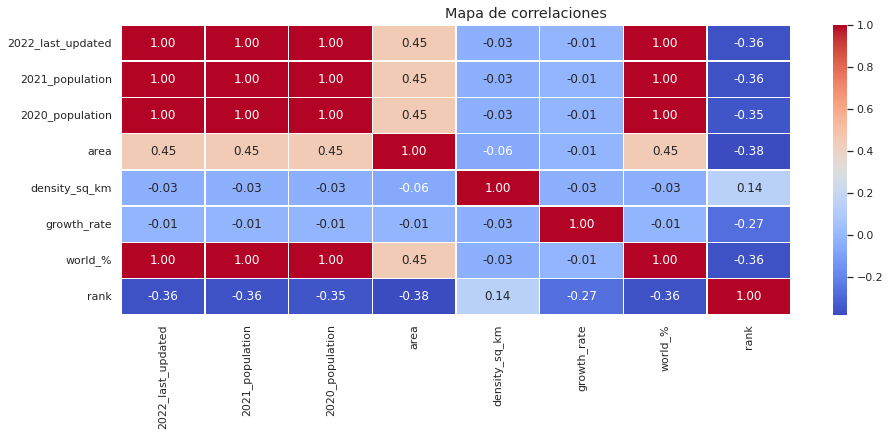

In [65]:
from matplotlib.figure import figaspect
sns.set()

fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(round(corr,2), annot=True, ax=ax, cmap='coolwarm', 
            fmt='.2f', linewidths=0.5)
fig.subplots_adjust(top=0.93)
fig.suptitle('Mapa de correlaciones')

In [66]:
def mapa_de_calor(corr):
  """Gráfica un mapa de calor de correlaciones escondiendo
  el triángulo superior."""
  mask = np.zeros_like(corr)
  mask[np.triu_indices_from(mask)] = True
  with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.heatmap(round(corr, 2), annot=True, ax=ax, cmap='coolwarm',
                fmt='.2f', linewidths=0.5, mask=mask)
    fig.subplots_adjust(top=0.93)
    fig.suptitle('Mapa de Correlaciones')

In [67]:
columnas_n = 
columnas = corr.nlargest(columnas_n, '2020_population')['2020_population'].index
columnas

Index(['2020_population', '2021_population', '2022_last_updated', 'world_%',
       'area'],
      dtype='object')

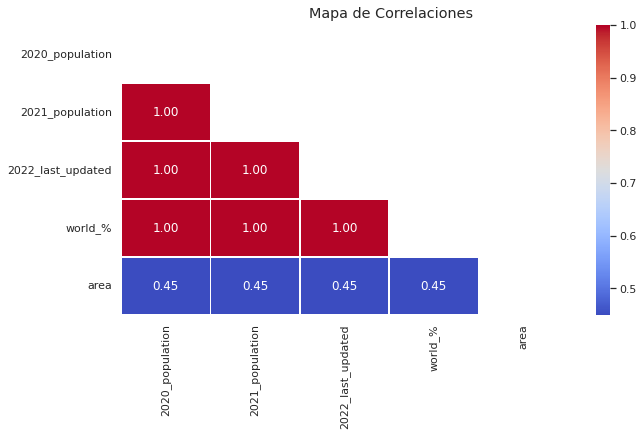

In [68]:
correlaciones = data_num[columnas].corr()
mapa_de_calor(correlaciones)

<Figure size 2160x1440 with 0 Axes>

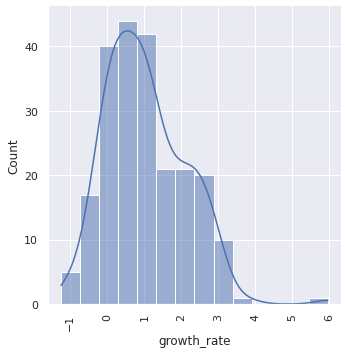

In [69]:
plt.figure(figsize=(30,20))
ax = sns.displot(data_num['growth_rate'], kde=True)
plt.xticks(rotation=90);

In [70]:
data_num['density_sq_km'].describe()

count      222.000000
mean       466.635135
std       2145.449094
min          0.000000
25%         35.250000
50%         96.000000
75%        238.250000
max      22250.000000
Name: density_sq_km, dtype: float64

In [71]:
print(f"Cesgo: {data_num['density_sq_km'].skew()}") #cesgo se espera en 1.3
print(f"Kurtosis: {data_num['density_sq_km'].kurt()}") #kurtosis se espera masomenos 5
#tomar en cuenta este comportamiento


Cesgo: 8.582451285059676
Kurtosis: 79.00553173345592


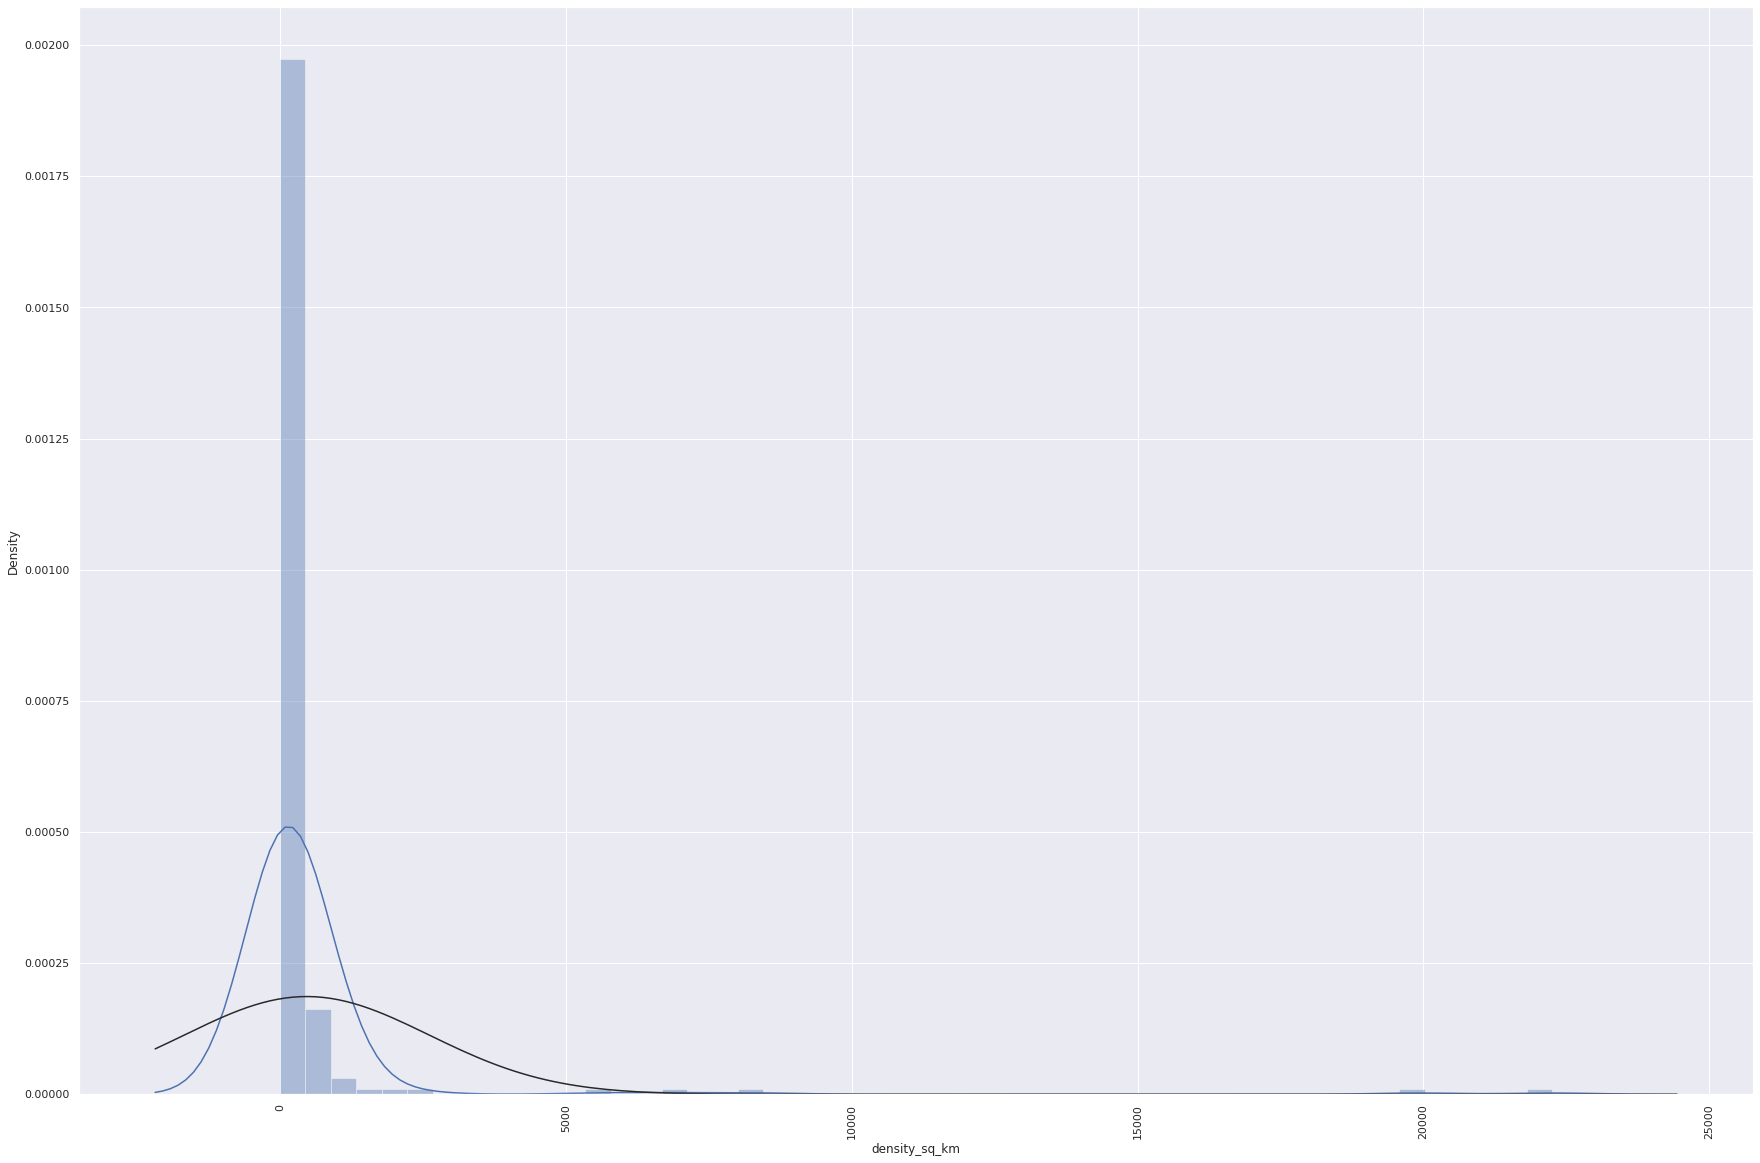

In [72]:
plt.figure(figsize=(30,20))
ax = sns.distplot(data_num['density_sq_km'], fit=norm)
plt.xticks(rotation=90);

In [73]:
# VARIABLES CATEGORICAS
 
data_categ.head()

,iso_code,country,continent
0,CHN,China,AS
1,IND,India,AS
2,USA,United States,NA
3,IDN,Indonesia,AS
4,PAK,Pakistan,AS


In [74]:
data_categ.shape

(222, 3)

Nombre de Columna:  iso_code
MAF    2
CHN    1
PRI    1
NAM    1
GMB    1
      ..
TUN    1
BOL    1
HTI    1
BEL    1
VAT    1
Name: iso_code, Length: 221, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


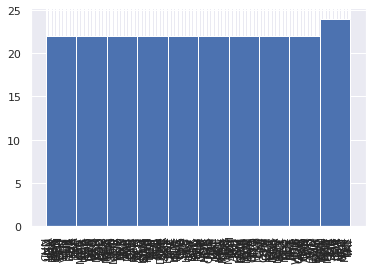

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Nombre de Columna:  country
China           1
Timor Leste     1
Gambia          1
Botswana        1
Gabon           1
               ..
Tunisia         1
Bolivia         1
Haiti           1
Belgium         1
Vatican City    1
Name: country, Length: 222, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


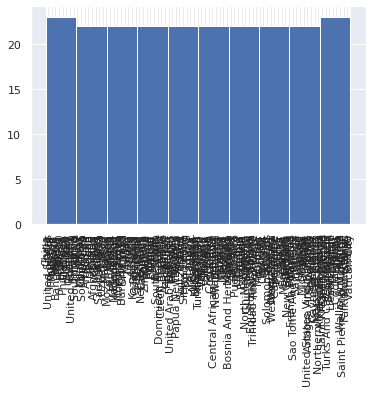

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Nombre de Columna:  continent
AF    53
AS    50
EU    47
NA    36
OC    23
SA    13
Name: continent, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


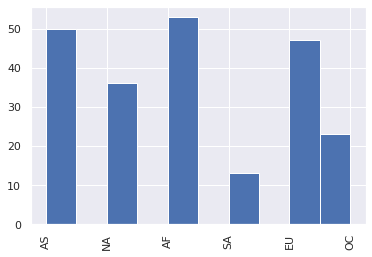

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [75]:
for columna in data_categ.columns:
  print(f'Nombre de Columna: ', columna)
  print(data_categ[columna].value_counts())
  print(data_categ[columna].hist(xrot=90))
  plt.show()
  print('~~~~~'*20)

In [76]:
data_categ_dummies = pd.get_dummies(data_categ)
data_categ_dummies.head()

,iso_code_ABW,iso_code_AFG,iso_code_AGO,iso_code_AIA,iso_code_ALB,iso_code_AND,iso_code_ARE,iso_code_ARG,iso_code_ARM,iso_code_ASM,iso_code_ATG,iso_code_AUS,iso_code_AUT,iso_code_AZE,iso_code_BDI,iso_code_BEL,iso_code_BEN,iso_code_BFA,iso_code_BGD,iso_code_BGR,iso_code_BHR,iso_code_BHS,iso_code_BIH,iso_code_BLR,iso_code_BLZ,iso_code_BMU,iso_code_BOL,iso_code_BRA,iso_code_BRB,iso_code_BRN,iso_code_BTN,iso_code_BWA,iso_code_CAF,iso_code_CAN,iso_code_CHE,iso_code_CHL,iso_code_CHN,iso_code_CIV,iso_code_CMR,iso_code_COK,...,country_Sweden,country_Switzerland,country_Syria,country_Taiwan,country_Tajikistan,country_Tanzania,country_Thailand,country_Timor Leste,country_Togo,country_Tokelau,country_Tonga,country_Trinidad And Tobago,country_Tunisia,country_Turkey,country_Turkmenistan,country_Turks And Caicos Islands,country_Tuvalu,country_Uganda,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_United States Virgin Islands,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Vatican City,country_Venezuela,country_Vietnam,country_Wallis And Futuna,country_Western Sahara,country_Yemen,country_Zambia,country_Zimbabwe,continent_AF,continent_AS,continent_EU,continent_NA,continent_OC,continent_SA
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


### SERIES DE TIEMPO (MODELO)

In [77]:
data_series = pd.read_csv('/content/drive/MyDrive/Población Mundial/timeseries_population_count.csv')

In [78]:
data_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59820 entries, 0 to 59819
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   iso_code            59820 non-null  object
 1   country             59820 non-null  object
 2   current_population  59820 non-null  object
 3   updated_datetime    59820 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [79]:
data_series.head()

,iso_code,country,current_population,updated_datetime
0,CHN,China,"1,443,839,846",2021-06-02 12:55:28.499834
1,IND,India,"1,392,365,583",2021-06-02 12:55:28.499834
2,USA,United States,"332,764,085",2021-06-02 12:55:28.499834
3,IDN,Indonesia,"276,140,523",2021-06-02 12:55:28.499834
4,PAK,Pakistan,"224,866,511",2021-06-02 12:55:28.499834


In [80]:
data_series['current_population'] = data_series['current_population'].str.replace(',','')
data_series['current_population'] = data_series['current_population'].astype('int64')

In [81]:
data_series['updated_datetime'] = data_series.updated_datetime.str.slice(0,10)
data_series['updated_datetime'] = data_series['updated_datetime'].astype('datetime64')

In [82]:
data_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59820 entries, 0 to 59819
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   iso_code            59820 non-null  object        
 1   country             59820 non-null  object        
 2   current_population  59820 non-null  int64         
 3   updated_datetime    59820 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.8+ MB


In [83]:
data_series.head()

,iso_code,country,current_population,updated_datetime
0,CHN,China,1443839846,2021-06-02
1,IND,India,1392365583,2021-06-02
2,USA,United States,332764085,2021-06-02
3,IDN,Indonesia,276140523,2021-06-02
4,PAK,Pakistan,224866511,2021-06-02


In [84]:
dates = ['2021-06-30', '2021-06-15', '2021-07-31', '2021-07-15', '2021-08-31', '2021-08-15', '2021-09-30', '2021-09-15', '2021-10-31', '2021-10-15', '2021-11-30','2021-11-15', '2021-12-30', '2021-12-14', '2022-01-31', '2022-01-15', '2022-02-24', '2022-02-10']

In [85]:
for date in dates:
  data_series.loc[data_series.updated_datetime == date, 'date_mensual'] = 'DATE'

In [86]:
india_time = data_series[(data_series.country == 'India') & (data_series.date_mensual=='DATE')]

In [87]:
#india_time.updated_datetime = pd.to_datetime(india_time.updated_datetime)

In [88]:
india_time.set_index('updated_datetime', inplace=True, drop=True)
india_time.drop(['iso_code', 'country', 'date_mensual'], axis=1, inplace=True)

In [89]:
india_time

,current_population
updated_datetime,
2021-06-15,1392841160
2021-06-30,1393391113
2021-07-15,1393941056
2021-07-31,1394527633
2021-08-15,1395077589
2021-08-31,1395664186
2021-09-15,1396214124
2021-09-30,1396764493
2021-10-15,1397314402


In [90]:
rcParams['figure.figsize'] = 10,5

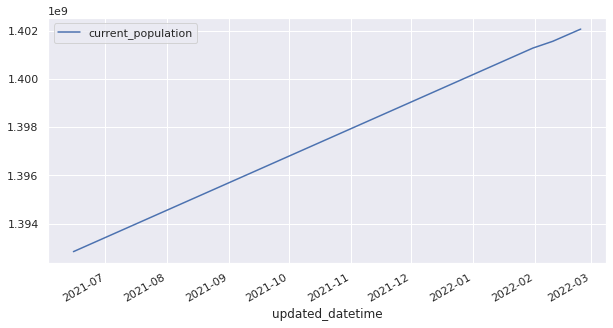

In [91]:
india_time.plot();

In [92]:
# fig, ax = plt.subplots(3, figsize=(15,10))

# plt.figure(facecolor='w')

# ax[0].plot(india_time, marker='o', markersize=3, markerfacecolor='b',
           #color='tab:orange')

# ax[1].plot(mexico_time, marker='o', markersize=3, markerfacecolor='r',
           #color='tab:blue')

# ax[2].plot(ucrania_time, marker='o', markersize=3, markerfacecolor='r',
           #color='tab:green');

In [93]:
def viewing_stationary(df, window=70):
  """Esta función genera un plot para una serie de tiempo
  con su media móvil y su desviación estandar."""
  # media móvil tomo una frecuencia de valores

  rolmean = df.rolling(window=window).mean()
  rolstd = df.rolling(window=window).std()

  fig= plt.figure(figsize=(10,5))
  time_series = plt.plot(df, color='blue', label='original')
  mean = plt.plot(rolmean, color='red', label='media móvil')
  std = plt.plot(rolstd, color='green', label='desviación estándar móvil')

  plt.legend(loc='best')
  plt.show();

In [94]:
class Stationary:
  def __init__(self, significance=0.5):
    self.significance_level = significance
    self.pvalue = None
    self.is_stationary =None

  def ADF(self, values):
    result = adfuller(values, autolag='AIC')

    format_results = pd.Series(result[:4], index=['Statistic', 'P-value',
                                                    'Num of Lags', 'Observations'])
      
    for k, v in result[4].items():
      format_results[f'Critical Value {k}'] = v

    return format_results

In [95]:
# ARGUMENTED DICKED FULLER TEST

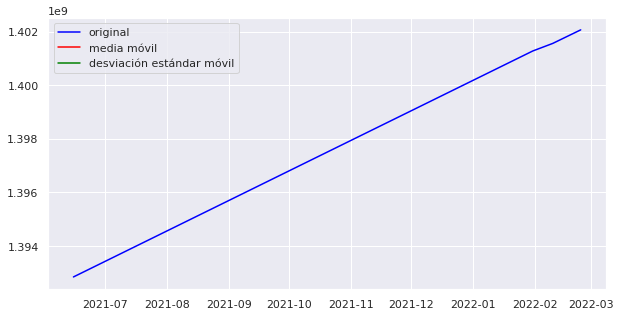

In [96]:
viewing_stationary(india_time, window=90) # pasos adelante de media movil

In [97]:
adf_test = Stationary()
adf_test.ADF(india_time['current_population'].values).round(5)

Statistic             -2.46180
P-value                0.12505
Num of Lags            7.00000
Observations          10.00000
Critical Value 1%     -4.33157
Critical Value 5%     -3.23295
Critical Value 10%    -2.74870
dtype: float64

In [98]:
 # Se acepta la hipotesis,no es estacionaria

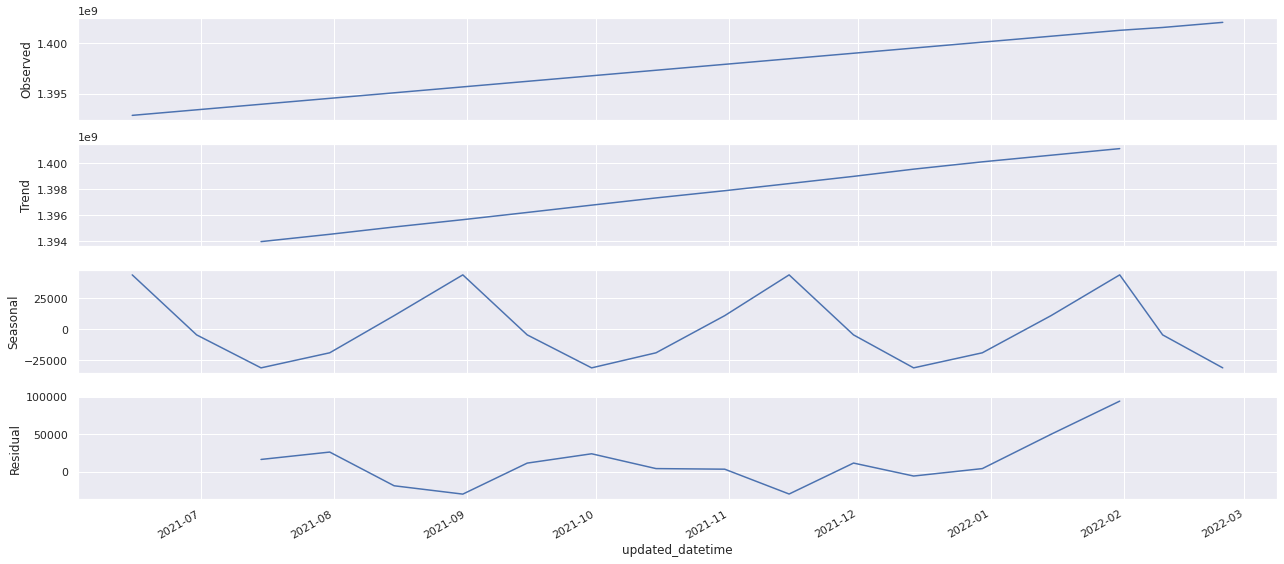

In [99]:
rcParams['figure.figsize'] = 18, 8
descomposition = sm.tsa.seasonal_decompose(india_time, freq=5)
# frecuencia un dia (24 horas por 60 entre la agrupación de 5 min)
fig = descomposition.plot()
plt.show();

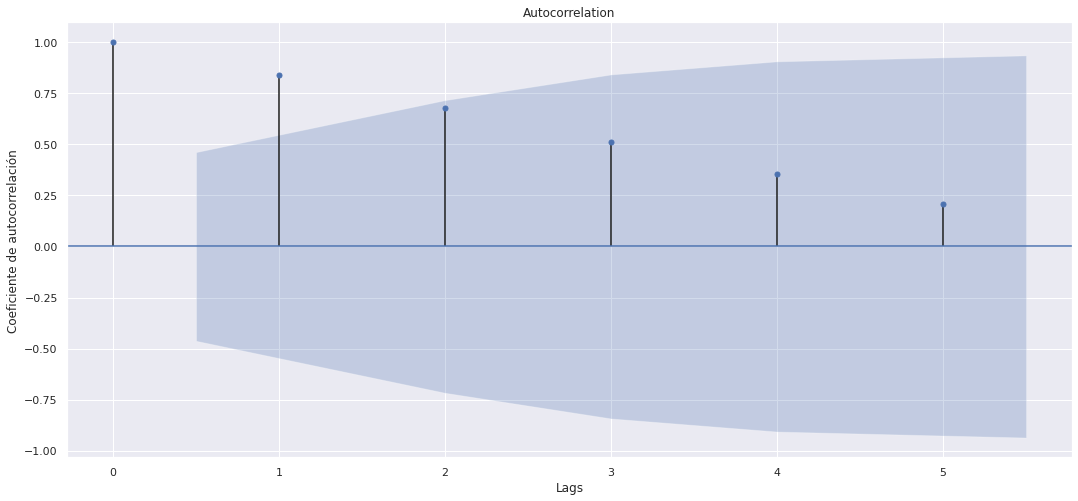

In [100]:
# GRAFICAS DE AUTOCORRELACIÓN

tsaplots.plot_acf(india_time['current_population'].values.squeeze(), lags=5)
# 
plt.xlabel('Lags')
plt.ylabel('Coeficiente de autocorrelación')
plt.show();

In [101]:
# DIFERENCIACIÓN

india_diff = india_time.copy()

In [102]:
india_diff['date_shift1'] = india_diff['current_population'].shift(1)

In [103]:
india_diff

,current_population,date_shift1
updated_datetime,,
2021-06-15,1392841160,NaN
2021-06-30,1393391113,1.392841e+09
2021-07-15,1393941056,1.393391e+09
2021-07-31,1394527633,1.393941e+09
2021-08-15,1395077589,1.394528e+09
2021-08-31,1395664186,1.395078e+09
2021-09-15,1396214124,1.395664e+09
2021-09-30,1396764493,1.396214e+09
2021-10-15,1397314402,1.396764e+09


In [104]:
india_diff['diff_1'] = india_diff['current_population'] - india_diff['date_shift1']

In [105]:
india_diff.head()

,current_population,date_shift1,diff_1
updated_datetime,,,
2021-06-15,1392841160,NaN,NaN
2021-06-30,1393391113,1.392841e+09,549953.0
2021-07-15,1393941056,1.393391e+09,549943.0
2021-07-31,1394527633,1.393941e+09,586577.0
2021-08-15,1395077589,1.394528e+09,549956.0


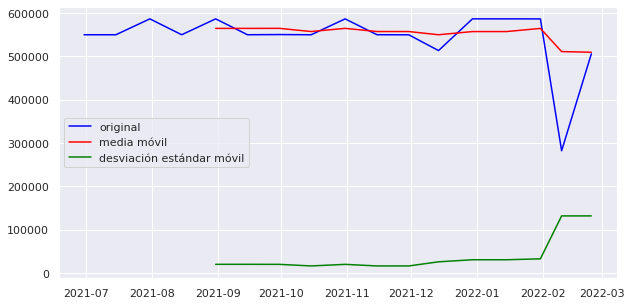

Statistic              0.608031
P-value                0.987812
Num of Lags            5.000000
Observations          11.000000
Critical Value 1%     -4.223238
Critical Value 5%     -3.189369
Critical Value 10%    -2.729839
dtype: float64

In [106]:
viewing_stationary(india_diff['diff_1'].dropna(), window=5)
adf_test = Stationary()
adf_test.ADF(india_diff['diff_1'].dropna().values).round(6)

In [107]:
# se aplica la diferenciación porque queremos volverla estacionaria 
# para poder aplicarle nuestro modelo

In [108]:
# ARIMA INDIA

In [109]:
p = d = q = range(0,3)
p, d, q

(range(0, 3), range(0, 3), range(0, 3))

In [110]:
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [111]:
india_time

,current_population
updated_datetime,
2021-06-15,1392841160
2021-06-30,1393391113
2021-07-15,1393941056
2021-07-31,1394527633
2021-08-15,1395077589
2021-08-31,1395664186
2021-09-15,1396214124
2021-09-30,1396764493
2021-10-15,1397314402


In [112]:
from traitlets.traitlets import Type
model = list()
aic = list()

for param in pdq:
  try:
    mod = SARIMAX(india_time,
                  order=param,
                  enforce_stationarity=False)
    results = mod.fit()
    model.append(param)
    aic.append(results.aic) # Aikake Information Criterion
    print('ARIMA{}-AIC{}'.format(param, results.aic))
  except(RuntimeError, TypeError, NameError):
    #print('')
    #print('No pude correr el modelo')
    print(RuntimeError)
    print(TypeError)
    print(NameError)
    continue

ARIMA(0, 0, 0)-AIC795313137528124.0
ARIMA(0, 0, 1)-AIC712.2908512744901
ARIMA(0, 0, 2)-AIC665.2877181375947
ARIMA(0, 1, 0)-AIC470.20122279349675
ARIMA(0, 1, 1)-AIC433.75389360597217
ARIMA(0, 1, 2)-AIC403.8607007501498
ARIMA(0, 2, 0)-AIC390.94042954177223
ARIMA(0, 2, 1)-AIC368.0387061150483
ARIMA(0, 2, 2)-AIC341.79376637966703
ARIMA(1, 0, 0)-AIC431.4953773585712
ARIMA(1, 0, 1)-AIC409.3530048550672
ARIMA(1, 0, 2)-AIC387.38677599979695
ARIMA(1, 1, 0)-AIC417.33392134607504
ARIMA(1, 1, 1)-AIC395.0693654268242
ARIMA(1, 1, 2)-AIC370.2365860182097
ARIMA(1, 2, 0)-AIC386.3783985845769
ARIMA(1, 2, 1)-AIC363.76173733541253
ARIMA(1, 2, 2)-AIC346.55638391197067
ARIMA(2, 0, 0)-AIC409.2711750930367
ARIMA(2, 0, 1)-AIC12820.750771473182
ARIMA(2, 0, 2)-AIC389.5529957450258
ARIMA(2, 1, 0)-AIC387.7046724328998
ARIMA(2, 1, 1)-AIC389.51594269278826
ARIMA(2, 1, 2)-AIC2104.5162750594095
ARIMA(2, 2, 0)-AIC363.6433593125044
ARIMA(2, 2, 1)-AIC1695.1076407089936
ARIMA(2, 2, 2)-AIC344.0606581374722


In [113]:
df_model_india = pd.DataFrame(zip(model, aic), columns=['model', 'aic'])
df_model_india.sort_values('aic').head()

,model,aic
8,"(0, 2, 2)",341.793766
26,"(2, 2, 2)",344.060658
17,"(1, 2, 2)",346.556384
24,"(2, 2, 0)",363.643359
16,"(1, 2, 1)",363.761737


In [114]:
model_india = SARIMAX(india_time, 
                    order=(0,2,2), 
                    enforce_stationarity=False)

results = model_india.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:     current_population   No. Observations:                   18
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -167.897
Date:                Sun, 27 Feb 2022   AIC                            341.794
Time:                        18:02:17   BIC                            343.489
Sample:                             0   HQIC                           341.445
                                 - 18                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2373      0.214     -1.110      0.267      -0.656       0.182
ma.L2          0.0212      0.035      0.609      0.543      -0.047       0.090
sigma2      1.119e+10   3.65e-12   3.07e+21      0.000    1.12e+10    1.12e+10
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                17.15
Prob(Q):                               nan   Prob(JB):                         0.00
Heteroskedasticity (H):             137.99   Skew:                            -1.84
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.85e+37. Standard errors may be unstable.
"""

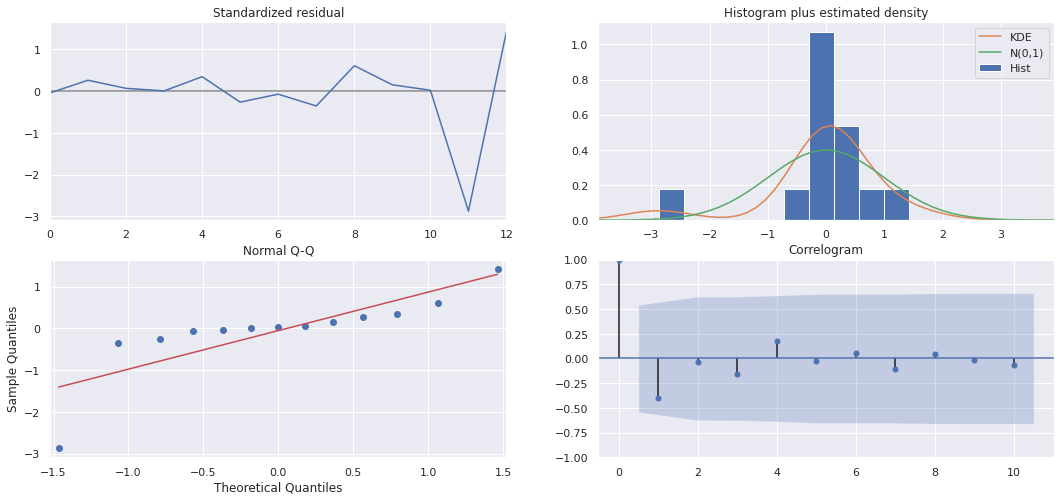

In [115]:
results.plot_diagnostics()
plt.show();

In [ ]:
# PREDICCIÓN 

In [116]:
india_time.shape[0] * 0.80

14.4

In [117]:
start = india_time.reset_index().iloc[15, 0]
end = india_time.reset_index().iloc[-1,0]

start, end

(Timestamp('2022-01-31 00:00:00'), Timestamp('2022-02-24 00:00:00'))

In [118]:
pred = results.predict(start=start, end=end)
pred_ci = results.get_prediction(start=start, end=end).conf_int()

df_pred = pd.DataFrame(pred, index=india_time.iloc[15:].index, columns=['current_population'])

In [119]:
df_pred.head()

,current_population
updated_datetime,
2022-01-31,1.401272e+09
2022-02-10,1.401860e+09
2022-02-24,1.401911e+09


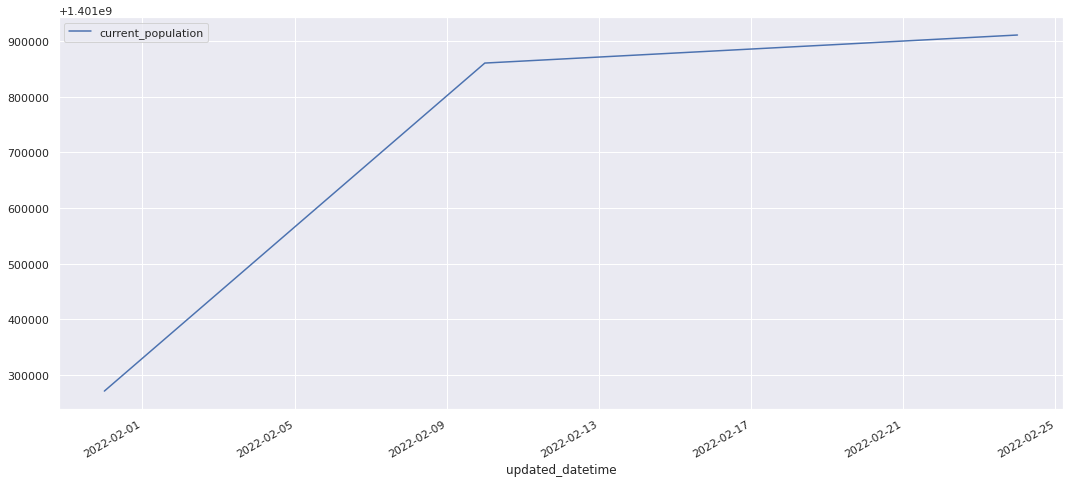

In [120]:
df_pred.plot();

In [121]:
pred_ci.head()

,lower current_population,upper current_population
updated_datetime,,
2022-01-31,1.401064e+09,1.401479e+09
2022-02-10,1.401653e+09,1.402067e+09
2022-02-24,1.401703e+09,1.402118e+09


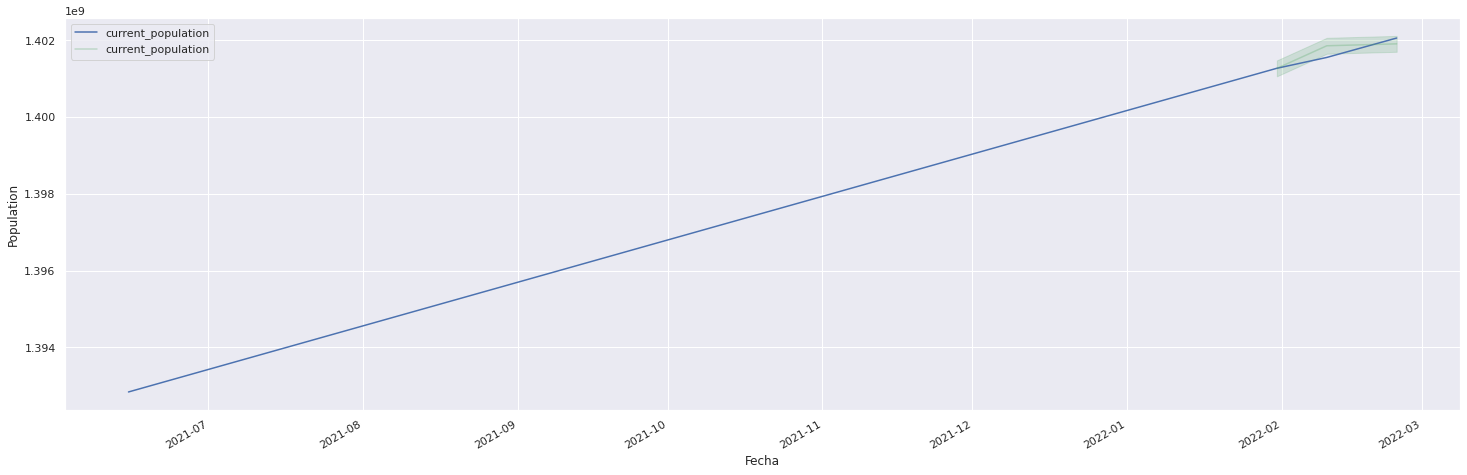

In [122]:
rcParams['figure.figsize'] = 25, 8

ax = india_time.plot(label='observado')
df_pred['current_population'].plot(c='g', alpha=0.3) 
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], 
                color='g', alpha=0.2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Population')
plt.legend()
plt.show()

In [123]:
india_time

,current_population
updated_datetime,
2021-06-15,1392841160
2021-06-30,1393391113
2021-07-15,1393941056
2021-07-31,1394527633
2021-08-15,1395077589
2021-08-31,1395664186
2021-09-15,1396214124
2021-09-30,1396764493
2021-10-15,1397314402


In [130]:
rcParams['figure.figsize'] = 30, 5

pred_uc = results.get_forecast(steps=365)
pred_ci = pred_uc.conf_int()

ax = india_time.plot(label='observado')

pred_uc.predicted_mean.plot(ax=ax, c='k', alpha=0.3, label='Predicción futura') 
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], 
                color='k', alpha=0.2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Población')
plt.legend()
plt.show()

     lower current_population  upper current_population
18               1.402318e+09              1.402733e+09
19               1.402572e+09              1.403412e+09
20               1.402784e+09              1.404134e+09
21               1.402960e+09              1.404891e+09
22               1.403104e+09              1.405680e+09
..                        ...                       ...
378              9.250120e+08              2.216065e+09
379              9.228002e+08              2.219210e+09
380              9.205846e+08              2.222359e+09
381              9.183654e+08              2.225512e+09
382              9.161425e+08              2.228668e+09

[365 rows x 2 columns]


ValueError: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fb1c675c5f0> (for post_execute):


ValueError: ignored

ValueError: ignored

<Figure size 2160x360 with 1 Axes>

In [ ]:
model_india = SARIMAX(india_time,
                order=(0, 2, 2),
                enforce_stationarity=False)

results = model_india.fit()
results.summary()

In [ ]:
results.plot_diagnostics()
plt.show()

In [1]:
rcParams['figure.figsize'] = 25, 8

pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = india_time.iloc[1000:].plot(label='Observado', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Predicción futura')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('Población')
plt.legend()
plt.show()

NameError: ignored